### Import required libraries

In [1]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE 
from collections import Counter
import pickle

%matplotlib inline

### Decrypt Credentials and Connect to Database

In [2]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the TEST dataset

In [3]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM TEST_DATA', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))

df.describe()
df.head()
print(df.columns)

--- 0.04061388969421387 seconds ---
Index(['?trackid', 'song', 'artist', 'year', 'lyrics', 'source', 'duration',
       ' loudness', ' mode', ' time_signature', ' words_song', ' words_genre',
       ' words_second', ' tempo', ' artist_hotttnesss', ' gnr_Blues',
       ' gnr_Country', ' gnr_Folk', ' gnr_Funk',
       ' gnr_House Electronic Trance', ' gnr_Jazz', ' gnr_Latin', ' gnr_Metal',
       ' gnr_Pop', ' gnr_Pop Standards', ' gnr_Punk', ' gnr_Rap Hip Hop',
       ' gnr_Rhythm and Blues', ' gnr_Rock', ' gnr_Rock and Roll',
       ' gnr_Ska Reggae Dancehall', ' key_0', ' key_1', ' key_2', ' key_4',
       ' key_5', ' key_6', ' key_7', ' key_8', ' key_9', ' key_10', ' key_11',
       ' is_top40'],
      dtype='object')


### Visualize only important features (not related with the rankings)

In [4]:
test_data = df.select_dtypes(include=['float64','int64','uint8']).copy()

test_data.drop(['source'], axis=1, inplace=True)
test_data.head()

,duration,loudness,mode,time_signature,words_song,words_genre,words_second,tempo,artist_hotttnesss,gnr_Blues,...,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,is_top40
0,223,-10.922,1,4,185,222,1,135,0.493990,0,...,0,0,0,0,0,0,0,1,0,1
1,179,-10.837,0,4,256,229,2,91,0.459346,0,...,0,0,0,0,0,0,1,0,0,1
2,301,-6.006,1,4,397,285,2,107,0.469921,0,...,0,0,0,0,0,0,0,0,1,1
3,110,-12.808,1,1,162,263,1,109,0.379651,0,...,0,1,0,0,0,0,0,0,0,1
4,244,-12.575,0,4,302,382,1,104,0.568201,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
array = test_data.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40

classes = ["IsTop40", "NoHit"]

def plotting(name, model, X_val, Y_val, X_train, Y_train):
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_val, Y_val)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data

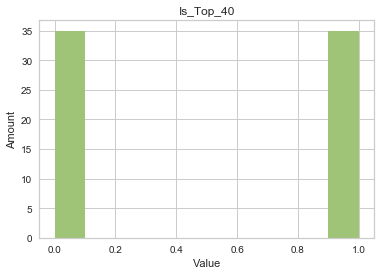

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(Y, facecolor='g')

plt.xlabel('Value')
plt.ylabel('Amount')
plt.title('Is_Top_40')
plt.grid(True)
plt.show()

### Random Forest Classifier

0.6428571428571429
0.6428571428571429
[[23 12]
 [13 22]]


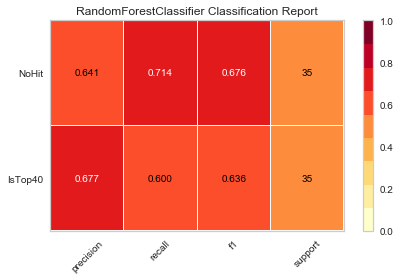

In [11]:
filename = 'RandomForestClassifier_model.sav'

loaded_model, X_train, Y_train = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

predictions = loaded_model.predict(X)
print(accuracy_score(Y, predictions))
print(confusion_matrix(Y, predictions))
plotting(filename, loaded_model, X, Y, X_train, Y_train)

### Logistic Regression

0.5285714285714286
0.5285714285714286
[[17 18]
 [15 20]]


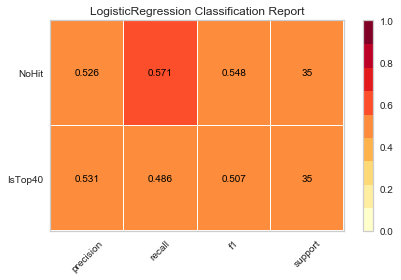

In [12]:
filename = 'LogisticRegression_model.sav'

loaded_model, X_train, Y_train = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

predictions = loaded_model.predict(X)
print(accuracy_score(Y, predictions))
print(confusion_matrix(Y, predictions))
plotting(filename, loaded_model, X, Y, X_train, Y_train)

### AdaBoost Classifier

0.5428571428571428
0.5428571428571428
[[15 20]
 [12 23]]


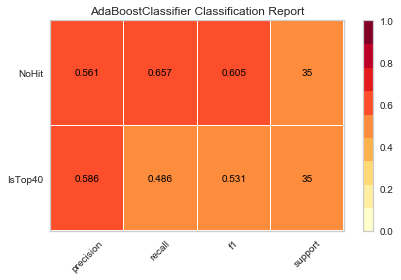

In [13]:
filename = 'AdaBoostClassifier_model.sav'

loaded_model, X_train, Y_train = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

predictions = loaded_model.predict(X)
print(accuracy_score(Y, predictions))
print(confusion_matrix(Y, predictions))
plotting(filename, loaded_model, X, Y, X_train, Y_train)